# Welcome to the Basics

This notebook will give you the essentials of DICOM and Reinforcement Learning. This should be sufficient for you to follow along with the process of the main code branch as well as start experimenting with your own PBT Reinforcement Learning training.

# DICOM

DICOM stands for Digital Imaging and Communications in Medicine and is the file type used in the Medical industry. These files will include CT scans, structure files (contour patient anatomy) and dose files (final plan dose distribution). The following will outline the pertinent code needed for using DICOM files in context of Proton Beam Therapy planning.

### Requirements

In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.6 MB/s eta 0:00:00


In [9]:
# Libraries
import pydicom as dcm
import matplotlib.pyplot as plt

# File paths to DICOM Files
ct_path = "/content/drive/MyDrive/PBT-GYM/data/CT_000032.dcm" # Needs to be changed to be relative to GitHub content
structure_path = ""

### CT files

In [10]:
# Read in CT file
ct_file = dcm.dcmread(ct_path)

# Important CT file contents
ct_image = ct_file.pixel_array
image_resolution = ct_file.PixelSpacing # Note different naming convention (Why? Who knows)
slice_id = ct_file.SOPInstanceUID
image_offset = ct_file.ImagePositionPatient

The above variables are the only contents of the CT file that are pertinent to this project (so far).


*   **ct_image** is a (512, 512) array
*   **image_resolution** is an array, [x,y], that gives the resolution of each pixel in the ct_image array in mm e.g [1,1] would mean each pixel corresponds to a 1x1mm square in real space
*   **slice_id** can be thought of as a tag. If the slice ReferencedSPOInstanceID (a member of the structure file) matches this tag, then they correspond to the same image slice
*   **image_offset** specifies the x, y and z coordinates of the upper left hand corner of the image



Using the example_data file to demonstrate, and running the example code should then give you the following:



```
[1.08, 1.08]
1.3.6.1.4.1.22213.2.26556.2.39
[-275.97, -275.91, -271.5]
```
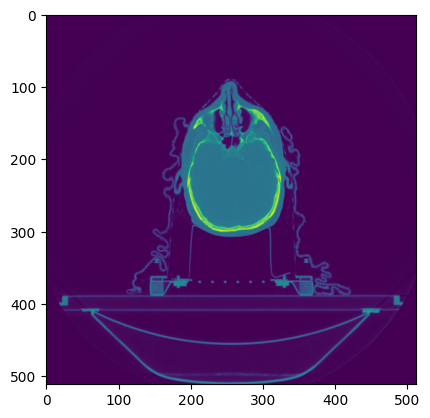


In [ ]:
# Printing other variables
print(image_resolution)
print(slice_id)
print(image_offset)

# Display CT image
plt.imshow(ct_image)

### Structure Files

Structure files contain all the information about the contours of different regions of interest (ROI) within the patient e.g Cancer, Brain Stem, Parotid etc.


Read in the structure file.
```
structure_file = dcm.dcmread(structure_path)
```
A breakdown of the file structure:

```
ROI_objects = structure_file.ROIContourSequence
```
This is an array containing information about each ROI in the structure file.

```
contour_slices = ROI_objects[index].ContourSequence # or structure_file.ROIContourSequence[index].ContourSequence
```
Each ROI contains a list of contour sequences containing the information on each slice in the ROI. (Now referencing a single ROI due to the [index] of the ROI Objects.)

NOTE: if there are multiple closed contours on a single slice they will be separate 'Contour Sequence' objects.

```
contour_coordinates = contour_slices.ContourData # Or structure_file.ROIContourSequence[index].ContourSequence[index].ContourData
```
This gives a list of all the [x, y] coordinates in a given slice of the contour. This coordinates can be used to create a closed contour.

NOTE: These coordinates are not in the same space as the CT scan so a coordinate transformation is required for these to be used together.


For any further data members required see the DICOM innolitics: https://dicom.innolitics.com/ciods/rt-structure-set/roi-contour/30060039/30060040


# Reinforcement Learning

### Requirements

In [ ]:
!pip install stable-baselines3[extra]

In [ ]:
!pip install gym[all]

In [ ]:
from gym import Env, spaces

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common.callbacks import EvalCallback

### Set up

Environment Class design:

In [ ]:
class MyCustomEnv(Env):                         # 1
    def __init__(self):                         # 2
        # Member Variables e.g
        self.state

    def step(self, action):                     # 3
        # Step logic

        return self.state, reward, done, info

    def reset(self):                            # 4
        # Environment reset e.g
        self.state = "Default State"



1.   Each custom environment Class needs to inherit from the OpenAI Gym Env() class
2.   A function that declares and defines the requisite member variables and their initial values
3.  Every environment requires a step function that handles the state, reward update due to the agents choice of action. NOTE: both step() and 'action' are key words here so cannot be replaced or misspelled. state, reward (double), done (bool), info (dict) are required returns, in that order.
4.  Similar to the step function, every environment requires a reset() method that is called when the 'done' variable return in the step() method is true, or when the episode reaches its step limit. As with step(), reset() is a key word.



Testing:

In [ ]:
env = MyCustomEnv()                             # 1

check_env(env)                                  # 2

env.render()                                    # 3



1.   Create an instance of your custom environment class
2.   Use the stable baselines method for checking your environment for errors and compatibility
3. Not necessary but creating a .render() method can be a useful diagnostic tool



Training:

In [ ]:
num_processors = 1                                      # 1

env = make_vec_env(MyCustomEnv, n_envs=num_processors)  # 2

model = PPO('MultiInputPolicy', env, verbose=1,         # 3
            device="cuda", n_steps=512)

n_timesteps = 1e6                                       # 4

model.learn(n_timesteps)                                # 5


1.  Choose the number of environments to be run in parallel *
2.  Alternative method of creating an instance of your custom environment *
3.  Create the model that is to be trained. This model uses PPO algorithm from stable baselines. The arguments are the policy, environment, verbosity (continuous print outs of results), which device to run on and the number of steps per episode of learning.
4.  Set the total number of steps for the entire training period
5.  Start training the model

if using vectorized environments *

For details on saving and loading models, wrapping environments and tensorboard integration (would definitely recommend, it's great) see the Stable Baselines docs: https://stable-baselines.readthedocs.io/en/master/

